### This is for all imports

In [297]:
import random
import itertools
import time
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import numpy as np
from memory_profiler import memory_usage

In [299]:
class VariableNode:
    def __init__(self, name, domain):
        self.name = name
        self.domain = domain
        self.neighbors = []
        self.received_messages = {}
        self.utility_upper_bounds = {}

    def compute_message(self, target_function, use_gd2p=False):
        total = defaultdict(int)
        for fn in self.neighbors:
            if fn.name == target_function.name:
                continue
            if fn.name in self.received_messages:
                msg = self.received_messages[fn.name]
                for val, score in enumerate(msg):
                    total[val] += score
        message = [total[val] for val in range(len(self.domain))]
        if use_gd2p:
            self.utility_upper_bounds[target_function.name] = max(message)
        return message

### In this section we have implemented Max-Sum, GDP, FDSP, GD2P

In [587]:
class FunctionNode:
    def __init__(self, name, scope, cost_table=None, cost_type="uniform", cost_range=(1, 100), coordination_bias=False):
        self.name = name
        self.scope = scope
        self.neighbors = scope
        self.received_messages = {}
        self.cost_table = cost_table or self._generate_random_table(cost_type, cost_range, coordination_bias)
        self.pruned_states = 0
        self.sorted_assignments = defaultdict(dict)
        self.fdsp_pruned_count = 0

    def _generate_random_table(self, cost_type, cost_range, coordination_bias):
        domain_lists = [v.domain for v in self.scope]
        cost_table = {}
        for assignment in itertools.product(*domain_lists):
            if coordination_bias:
                # If all values are the same → low cost; else high cost
                if all(val == assignment[0] for val in assignment):
                    cost = random.uniform(cost_range[0], (cost_range[0] + cost_range[1]) / 4)
                else:
                    cost = random.uniform((cost_range[1] + cost_range[0]) / 2, cost_range[1])
            else:
                if cost_type == "gaussian":
                    cost = max(0.0, random.gauss(mu=(cost_range[0] + cost_range[1]) / 2,
                                                 sigma=(cost_range[1] - cost_range[0]) / 6))
                elif cost_type == "uniform":
                    cost = random.uniform(*cost_range)
                else:
                    cost = random.randint(*cost_range)
            cost_table[assignment] = round(cost, 3)
        return cost_table


    def get_cost(self, assignment):
        key = tuple(assignment[v.name] for v in self.scope)
        return self.cost_table.get(key, 0)

    def _precompute_sorted_assignments(self):
        for var in self.scope:
            self.sorted_assignments[var.name] = {}
            for val in var.domain:
                assignments = []
                other_vars = [v for v in self.scope if v != var]
                for other_vals in itertools.product(*[v.domain for v in other_vars]):
                    full_assignment = {v.name: ov for v, ov in zip(other_vars, other_vals)}
                    full_assignment[var.name] = val
                    cost = self.get_cost(full_assignment)
                    assignments.append((cost, other_vals))
                assignments.sort(key=lambda x: -x[0])
                self.sorted_assignments[var.name][val] = assignments

    def compute_message(self, target_variable, use_gdp=False, use_gd2p=False):
        if use_gdp:
            return self._gdp_message_optimized(target_variable)
        elif use_gd2p:
            return self._gd2p_message(target_variable)
        else:
            return self._standard_message(target_variable)

    def _standard_message(self, target_variable):
        domain = target_variable.domain
        message = [float('-inf')] * len(domain)
        other_vars = [v for v in self.scope if v != target_variable]
        for assignment in itertools.product(*[v.domain for v in other_vars]):
            partial = {v.name: val for v, val in zip(other_vars, assignment)}
            msg_sum = sum(
                self.received_messages[v.name][val]
                for v, val in zip(other_vars, assignment)
                if v.name in self.received_messages
            )
            for i, dval in enumerate(domain):
                full_assignment = partial.copy()
                full_assignment[target_variable.name] = dval
                cost = self.get_cost(full_assignment)
                total = cost + msg_sum
                message[i] = max(message[i], total)
        return message

    def _gdp_message_optimized(self, target_variable):
        domain = target_variable.domain
        message = [float('-inf')] * len(domain)
        other_vars = [v for v in self.scope if v != target_variable]
        
        # Pre-sort utility values for each state (Line 2 of Algorithm 1)
        self._precompute_sorted_assignments()
        
        # Compute m ONCE (sum of max incoming messages) (Line 4)
        m = sum(max(self.received_messages.get(v.name, [0])) for v in other_vars)
    
        for val_idx, dval in enumerate(domain):
            sorted_entries = self.sorted_assignments[target_variable.name][dval]
            if not sorted_entries:
                continue
    
            # Get p = max utility for this state (Line 7)
            p, max_assignment = sorted_entries[0]
            
            # Compute b = sum of incoming messages for p's assignment (Line 8)
            b = sum(
                self.received_messages[v.name][assigned_val]
                for v, assigned_val in zip(other_vars, max_assignment)
                if v.name in self.received_messages
            )
            
            t = m - b  # Line 9
            q_target = p - t  # Target threshold (Line 10)
    
            # Binary search to find q (largest value <= q_target)
            left, right = 0, len(sorted_entries)
            while left < right:
                mid = (left + right) // 2
                cost, _ = sorted_entries[mid]
                if cost >= q_target:
                    left = mid + 1
                else:
                    right = mid
            q_idx = left - 1 if left > 0 else 0
    
            # Count pruned states (all entries after q_idx)
            self.pruned_states += len(sorted_entries) - (q_idx + 1)
    
            # Only process the pruned range [0, q_idx] (Lines 11-14)
            for cost, other_vals in sorted_entries[:q_idx + 1]:
                msg_sum = sum(
                    self.received_messages[v.name][val]
                    for v, val in zip(other_vars, other_vals)
                    if v.name in self.received_messages
                )
                message[val_idx] = max(message[val_idx], cost + msg_sum)

    
        return message
            
           

    def _gd2p_message(self, target_variable):
        domain = target_variable.domain
        message = [float('-inf')] * len(domain)
        other_vars = [v for v in self.scope if v != target_variable]
        
        # Precompute sorted assignments (by descending local utility)
        self._precompute_sorted_assignments()
        
        # Sum of max incoming messages (msgUB in paper)
        msgUB = sum(max(self.received_messages.get(v.name, [0])) for v in other_vars)
        
        for val_idx, dval in enumerate(domain):
            sorted_entries = self.sorted_assignments[target_variable.name][dval]
            if not sorted_entries:
                continue
                
            util_star = -float('inf')  # Best total utility found so far
            lb = -float('inf')         # Lower bound (util* - msgUB)
            
            for cost, other_vals in sorted_entries:
                # Paper's exact pruning condition: F_j(e) < lb (line 11)
                if cost < lb:
                    self.pruned_states += len(sorted_entries) - sorted_entries.index((cost, other_vals))
                    break
                    
                # Compute total utility
                msg_sum = sum(
                    self.received_messages[v.name][other_vals[i]]
                    for i, v in enumerate(other_vars)
                    if v.name in self.received_messages
                )
                total = cost + msg_sum
                
                # Update best solution and lower bound (lines 16-17)
                if total > util_star:
                    util_star = total
                    lb = util_star - msgUB
                
                # Update message
                message[val_idx] = max(message[val_idx], total)
                    
        return message
                

    def _fdsp_precompute(self):
        self.fun_est = {}
        self.informed_fun_est = {}
        self.var_order = [v.name for v in self.scope]
        n = len(self.var_order)

        for i in reversed(range(n)):
            var = self.var_order[i]
            self.fun_est[var] = {}
            if i == n - 1:
                for assignment in itertools.product(*[v.domain for v in self.scope]):
                    key = tuple(assignment)
                    self.fun_est[var][key[:i+1]] = self.get_cost({v.name: val for v, val in zip(self.scope, assignment)})
            else:
                next_var = self.var_order[i+1]
                for partial_assignment in itertools.product(*[v.domain for v in self.scope[:i+1]]):
                    max_val = -float('inf')
                    for next_val in self.scope[i+1].domain:
                        full_assignment = partial_assignment + (next_val,)
                        max_val = max(max_val, self.fun_est[next_var].get(full_assignment, -float('inf')))
                    self.fun_est[var][partial_assignment] = max_val

        for j in range(n):
            target_var = self.var_order[j]
            self.informed_fun_est[target_var] = {}
            for target_val in self.scope[j].domain:
                self.informed_fun_est[target_var][target_val] = {}
                for i in reversed(range(j)):
                    var = self.var_order[i]
                    self.informed_fun_est[target_var][target_val][var] = {}
                    if i == j - 1:
                        for partial_assignment in itertools.product(*[v.domain for v in self.scope[:i+1]]):
                            full_assignment = partial_assignment + (target_val,)
                            self.informed_fun_est[target_var][target_val][var][partial_assignment] = \
                                self.fun_est[self.var_order[j-1]].get(full_assignment, -float('inf'))
                    else:
                        next_var = self.var_order[i+1]
                        for partial_assignment in itertools.product(*[v.domain for v in self.scope[:i+1]]):
                            max_val = -float('inf')
                            for next_val in self.scope[i+1].domain:
                                full_assignment = partial_assignment + (next_val,)
                                max_val = max(max_val,
                                    self.informed_fun_est[target_var][target_val][next_var].get(full_assignment, -float('inf')))
                            self.informed_fun_est[target_var][target_val][var][partial_assignment] = max_val

    # def _fdsp_message(self, target_variable):
    #     self.fdsp_pruned_count = 0
    #     message = [float('-inf')] * len(target_variable.domain)
    #     target_idx = self.var_order.index(target_variable.name)
    #     other_vars = [v for v in self.scope if v != target_variable]

    #     msg_est = {}
    #     msg_est[self.var_order[-1]] = 0
    #     for i in reversed(range(len(self.var_order))):
    #         if self.var_order[i] == target_variable.name:
    #             continue
    #         if i == len(self.var_order) - 1:
    #             continue
    #         next_var = self.var_order[i+1]
    #         msg_val = self.received_messages.get(next_var, [0])
    #         msg_est[self.var_order[i]] = msg_est.get(next_var, 0) + max(msg_val)



    #     for val_idx, target_val in enumerate(target_variable.domain):
    #         best_util = -float('inf')
    #         stack = [(0, {target_variable.name: target_val}, 0)]
    #         while stack:
    #             var_idx, assignment, msg_sum = stack.pop()
    #             if var_idx >= len(self.var_order):
    #                 current_util = self.get_cost(assignment) + msg_sum
    #                 best_util = max(best_util, current_util)
    #                 continue
    #             var_name = self.var_order[var_idx]
    #             if var_name == target_variable.name:
        #             stack.append((var_idx+1, assignment, msg_sum))
        #             continue
        #         current_var = self.scope[var_idx]
        #         for val in current_var.domain:
        #             new_assignment = assignment.copy()
        #             new_assignment[current_var.name] = val
        #             new_msg_sum = msg_sum + self.received_messages.get(current_var.name, [0])[val]
        #             partial_key = tuple(new_assignment.get(v.name, None) for v in self.scope[:var_idx+1])
        #             if var_idx < target_idx:
        #                 fun_ub = self.informed_fun_est[target_variable.name][target_val][current_var.name].get(partial_key, -float('inf'))
        #             else:
        #                 fun_ub = self.fun_est[current_var.name].get(partial_key, -float('inf'))
        #             msg_ub = msg_est.get(self.var_order[var_idx], 0)
        #             total_ub = new_msg_sum + msg_ub + fun_ub
        #             if total_ub <= best_util:
        #                 self.fdsp_pruned_count += 1  # Count pruned branches
        #                 continue
        #             if total_ub > best_util:
        #                 stack.append((var_idx+1, new_assignment, new_msg_sum))
        #     message[val_idx] = best_util
        # return message

    def _fdsp_message(self, target_variable):
        self.fdsp_pruned_count = 0
        message = [float('-inf')] * len(target_variable.domain)
        target_idx = self.var_order.index(target_variable.name)
        
        # Precompute message estimations (unchanged)
        msg_est = {}
        msg_est[self.var_order[-1]] = 0
        for i in reversed(range(len(self.var_order))):
            if self.var_order[i] == target_variable.name:
                continue
            if i == len(self.var_order) - 1:
                continue
            next_var = self.var_order[i+1]
            msg_val = self.received_messages.get(next_var, [0])
            msg_est[self.var_order[i]] = msg_est.get(next_var, 0) + max(msg_val)
    
        for val_idx, target_val in enumerate(target_variable.domain):
            best_util = -float('inf')
            stack = [(0, {target_variable.name: target_val}, 0, False)]
            total_nodes = 0  # Track total possible nodes
            pruned_nodes = 0  # Track actually pruned nodes
            
            while stack:
                var_idx, assignment, msg_sum, is_pruned = stack.pop()
                
                if is_pruned:
                    pruned_nodes += 1
                    continue
                    
                if var_idx >= len(self.var_order):
                    current_util = self.get_cost(assignment) + msg_sum
                    best_util = max(best_util, current_util)
                    continue
                    
                var_name = self.var_order[var_idx]
                if var_name == target_variable.name:
                    stack.append((var_idx+1, assignment, msg_sum, False))
                    continue
                    
                current_var = self.scope[var_idx]
                domain_size = len(current_var.domain)
                total_nodes += domain_size  # Each value is a potential branch
                
                # Push children in reverse order for DFS
                for val in reversed(current_var.domain):
                    new_assignment = assignment.copy()
                    new_assignment[current_var.name] = val
                    new_msg_sum = msg_sum + self.received_messages.get(current_var.name, [0])[val]
                    partial_key = tuple(new_assignment.get(v.name, None) for v in self.scope[:var_idx+1])
                    
                    if var_idx < target_idx:
                        fun_ub = self.informed_fun_est[target_variable.name][target_val][current_var.name].get(partial_key, -float('inf'))
                    else:
                        fun_ub = self.fun_est[current_var.name].get(partial_key, -float('inf'))
                        
                    msg_ub = msg_est.get(self.var_order[var_idx], 0)
                    total_ub = new_msg_sum + msg_ub + fun_ub
                    
                    if total_ub <= best_util:
                        # Mark this branch as pruned
                        stack.append((var_idx+1, new_assignment, new_msg_sum, True))
                    else:
                        stack.append((var_idx+1, new_assignment, new_msg_sum, False))
                        
            # Calculate pruning percentage
            if total_nodes > 0:
                pruning_percentage = (pruned_nodes / total_nodes) * 100
                self.fdsp_pruned_count += pruned_nodes
                # print(f"For value {target_val}: Pruned {pruning_percentage:.2f}% of branches")
                
            message[val_idx] = best_util
            
        return message

In [621]:
class DCOPGraph:
    def __init__(self, num_vars, domain_size, arity, dense=False,
                 cost_type="uniform", cost_range=(1, 100), random_arity=False,
                 coordination_bias=False):
        self.variables = []
        self.functions = []
        self._build_graph(num_vars, domain_size, arity, dense,
                          cost_type, cost_range, random_arity, coordination_bias)

    def _build_graph(self, num_vars, domain_size, arity, dense,
                     cost_type, cost_range, random_arity, coordination_bias):
        self.variables = [VariableNode(f"x{i}", list(range(domain_size))) for i in range(num_vars)]
        num_functions = num_vars
        for j in range(num_functions):
            current_arity = random.randint(2, arity) if random_arity else arity
            if dense:
                scope = random.sample(self.variables, min(current_arity, len(self.variables)))
            else:
                start = j % (len(self.variables) - current_arity + 1)
                scope = self.variables[start:start + current_arity]
            func_node = FunctionNode(f"f{j}", scope,
                                     cost_type=cost_type,
                                     cost_range=cost_range,
                                     coordination_bias=coordination_bias)
            self.functions.append(func_node)
            for var in scope:
                var.neighbors.append(func_node)

    def get_factor_graph(self):
        graph = {var.name: [fn.name for fn in var.neighbors] for var in self.variables}
        graph.update({fn.name: [v.name for v in fn.scope] for fn in self.functions})
        return graph

    def run_max_sum(self, iterations=10, use_gdp=False, use_gd2p=False, use_fdsp=False):
        start_time = time.time()

        if use_fdsp:
            for fn in self.functions:
                fn._fdsp_precompute()

        for _ in range(iterations):
            for var in self.variables:
                for fn in var.neighbors:
                    msg = var.compute_message(fn, use_gd2p=use_gd2p)
                    fn.received_messages[var.name] = msg

            for fn in self.functions:
                for var in fn.scope:
                    if use_fdsp:
                        # Ensure all required upper bounds are initialized
                        for v in fn.scope:
                            if v.name not in fn.received_messages:
                                fn.received_messages[v.name] = [0] * len(v.domain)

                        msg = fn._fdsp_message(var)
                    else:
                        msg = fn.compute_message(var, use_gdp=use_gdp, use_gd2p=use_gd2p)
                    var.received_messages[fn.name] = msg

        runtime = time.time() - start_time
        pruned = 0
        if use_gdp or use_gd2p:
            pruned = sum(fn.pruned_states for fn in self.functions)
        elif use_fdsp:
            pruned = sum(fn.fdsp_pruned_count for fn in self.functions)
        
        return runtime, pruned

    def get_solution(self):
        assignment = {}
        for var in self.variables:
            belief = [0] * len(var.domain)
            for msg in var.received_messages.values():
                for i in range(len(var.domain)):
                    belief[i] += msg[i]
            best_val = max(range(len(belief)), key=lambda i: belief[i])
            assignment[var.name] = var.domain[best_val]
        return assignment

    def visualize(self):
        G = nx.Graph()
        for var in self.variables:
            G.add_node(var.name, color='skyblue', shape='o')
        for fn in self.functions:
            G.add_node(fn.name, color='lightgreen', shape='s')
            for v in fn.scope:
                G.add_edge(fn.name, v.name)

        colors = [G.nodes[n]['color'] for n in G.nodes()]
        shapes = set((aShape[1]["shape"] for aShape in G.nodes(data=True)))
        pos = nx.spring_layout(G, seed=42)

        for shape in shapes:
            nx.draw_networkx_nodes(G, pos,
                                   nodelist=[sNode[0] for sNode in filter(lambda x: x[1]["shape"] == shape, G.nodes(data=True))],
                                   node_color=[sNode[1]["color"] for sNode in filter(lambda x: x[1]["shape"] == shape, G.nodes(data=True))],
                                   node_shape=shape,
                                   node_size=800)

        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos)
        plt.title("DCOP Factor Graph")
        plt.axis('off')
        plt.show()

    def print_structure(self):
        for var in self.variables:
            print(f"Variable {var.name}: Domain = {var.domain}, Neighbors = {[f.name for f in var.neighbors]}")
        for fn in self.functions:
            print(f"Function {fn.name}: Scope = {[v.name for v in fn.scope]}")

### Test Message Passing

In [624]:
graph = DCOPGraph(
    num_vars=10,             # Moderate problem size
    domain_size=4,           # Small to moderate domain
    arity=2,                 # Low arity = easier propagation
    dense=False,             # Sparse graph suits GD2P
    cost_type="uniform",     # Smooth cost space
    cost_range=(0, 10),      # Low-cost variability
    random_arity=False,      # Keep things simple
    coordination_bias=True   # Encourages coordination, which GD2P handles well
)

graph.print_structure()
t1, pruned1=graph.run_max_sum(iterations=10,use_gdp=False)
solution = graph.get_solution()
g= graph.get_factor_graph()

Variable x0: Domain = [0, 1, 2, 3], Neighbors = ['f0', 'f9']
Variable x1: Domain = [0, 1, 2, 3], Neighbors = ['f0', 'f1', 'f9']
Variable x2: Domain = [0, 1, 2, 3], Neighbors = ['f1', 'f2']
Variable x3: Domain = [0, 1, 2, 3], Neighbors = ['f2', 'f3']
Variable x4: Domain = [0, 1, 2, 3], Neighbors = ['f3', 'f4']
Variable x5: Domain = [0, 1, 2, 3], Neighbors = ['f4', 'f5']
Variable x6: Domain = [0, 1, 2, 3], Neighbors = ['f5', 'f6']
Variable x7: Domain = [0, 1, 2, 3], Neighbors = ['f6', 'f7']
Variable x8: Domain = [0, 1, 2, 3], Neighbors = ['f7', 'f8']
Variable x9: Domain = [0, 1, 2, 3], Neighbors = ['f8']
Function f0: Scope = ['x0', 'x1']
Function f1: Scope = ['x1', 'x2']
Function f2: Scope = ['x2', 'x3']
Function f3: Scope = ['x3', 'x4']
Function f4: Scope = ['x4', 'x5']
Function f5: Scope = ['x5', 'x6']
Function f6: Scope = ['x6', 'x7']
Function f7: Scope = ['x7', 'x8']
Function f8: Scope = ['x8', 'x9']
Function f9: Scope = ['x0', 'x1']


### Factor Graph

{'x0': ['f0', 'f9'], 'x1': ['f0', 'f1', 'f9'], 'x2': ['f1', 'f2'], 'x3': ['f2', 'f3'], 'x4': ['f3', 'f4'], 'x5': ['f4', 'f5'], 'x6': ['f5', 'f6'], 'x7': ['f6', 'f7'], 'x8': ['f7', 'f8'], 'x9': ['f8'], 'f0': ['x0', 'x1'], 'f1': ['x1', 'x2'], 'f2': ['x2', 'x3'], 'f3': ['x3', 'x4'], 'f4': ['x4', 'x5'], 'f5': ['x5', 'x6'], 'f6': ['x6', 'x7'], 'f7': ['x7', 'x8'], 'f8': ['x8', 'x9'], 'f9': ['x0', 'x1']}


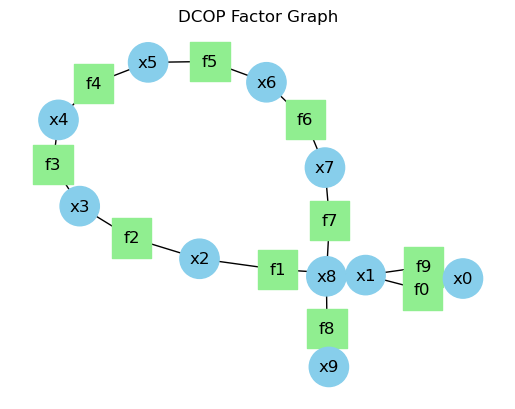

In [627]:
print(g)
graph.visualize()

### Solution

In [630]:
print(f"Vanilla: Time = {t1:.4f}s, Pruned = {pruned1}")
print(solution)

Vanilla: Time = 0.0050s, Pruned = 0
{'x0': 0, 'x1': 1, 'x2': 2, 'x3': 1, 'x4': 0, 'x5': 1, 'x6': 3, 'x7': 1, 'x8': 3, 'x9': 0}


### Running GDP

In [633]:
t2, pruned2=graph.run_max_sum(iterations=10,use_gdp=True)
solution = graph.get_solution()
print(solution)
print(f"Optimized GDP: Time = {t2:.4f}s, Pruned = {pruned2}")

{'x0': 0, 'x1': 1, 'x2': 2, 'x3': 1, 'x4': 0, 'x5': 1, 'x6': 3, 'x7': 1, 'x8': 3, 'x9': 0}
Optimized GDP: Time = 0.0110s, Pruned = 1791


### Running GD2P

In [636]:
t, pruned = graph.run_max_sum(iterations=10,use_gd2p=True)
print(f"GD²P Time: {t:.4f}s, Pruned States: {pruned}")

GD²P Time: 0.0150s, Pruned States: 3651


### Running FDSP

In [645]:
t_fdsp, pruned_fdsp = graph.run_max_sum(iterations=10,use_fdsp=True)
print(f"FDSP Time: {t_fdsp:.4f}s, Pruned States: {pruned_fdsp}")

FDSP Time: 0.0072s, Pruned States: 160


In [661]:
class BenchmarkSuite:
    def __init__(self, num_vars=6, domain_size=4, arity=3, dense=False, iterations=10):
        self.num_vars = num_vars
        self.domain_size = domain_size
        self.arity = arity
        self.dense = dense
        self.iterations = iterations
        self.results = []
        self.random_seed = 42

    def _run_single_case(self, algorithm):
        """Run a single algorithm case matching your run_max_sum signature"""
        np.random.seed(self.random_seed)
        random.seed(self.random_seed)
        
        g = DCOPGraph(
            num_vars=self.num_vars,
            domain_size=self.domain_size,
            arity=self.arity,
            dense=self.dense
        )
        
        # Map algorithm names to your boolean flags
        if algorithm == 'vanilla':
            kwargs = {'use_gdp': False, 'use_gd2p': False, 'use_fdsp': False}
        elif algorithm == 'gdp':
            kwargs = {'use_gdp': True, 'use_gd2p': False, 'use_fdsp': False}
        elif algorithm == 'gd2p':
            kwargs = {'use_gdp': False, 'use_gd2p': True, 'use_fdsp': False}
        elif algorithm == 'fdsp':
            kwargs = {'use_gdp': False, 'use_gd2p': False, 'use_fdsp': True}
        else:
            raise ValueError(f"Unknown algorithm: {algorithm}")
        
        start_time = time.time()
        runtime, pruned = g.run_max_sum(iterations=self.iterations, **kwargs)
        
        return {
            "runtime": runtime,
            "pruned": pruned,
            "utility": sum(fn.get_cost(g.get_solution()) for fn in g.functions),
            "memory_peak": None  # Can add memory profiling later if needed
        }

    def run_all_algorithms(self):
        """Run all algorithms with current settings"""
        self.results = []
        
        algorithms = [
            ('vanilla', 'Max-Sum'),
            ('gdp', 'GDP'),
            ('gd2p', 'GD²P'), 
            ('fdsp', 'FDSP')
        ]
        
        for algo_key, algo_name in algorithms:
            result = self._run_single_case(algo_key)
            self.results.append({
                "algorithm": algo_name,
                "runtime": result["runtime"],
                "pruned": result["pruned"], 
                "utility": result["utility"],
                "domain_size": self.domain_size,
                "arity": self.arity,
                "dense": self.dense,
                "iterations": self.iterations
            })
        
    # def run_experiments_grid(self, domain_sizes, arities, densities, repetitions=3):
    #     """Full factorial experiment with statistical significance"""
    #     self.results = []
    #     configs = list(itertools.product(domain_sizes, arities, densities))
        
    #     for domain_size, arity, dense in tqdm(configs, desc="Experiment Grid"):
    #         self.domain_size = domain_size
    #         self.arity = arity
    #         self.dense = dense
            
    #         for rep in range(repetitions):
    #             self.domain_size = domain_size
    #             self.arity = arity
    #             self.dense = dense
    #             self.random_seed = 42 + rep  # Different seed per repetition
    #             self.run_all_algorithms()
    #     print(f"Total results collected: {len(self.results)}") 

    def run_experiments_grid(self, domain_sizes, arities, densities, repetitions):
        """Run all combinations of parameters"""
        self.results = []  # Clear previous results
        
        for domain_size in domain_sizes:
            for arity in arities:
                for dense in densities:
                    for rep in range(repetitions):
                        # Update configuration
                        self.domain_size = domain_size
                        self.arity = arity
                        self.dense = dense
                        self.random_seed = 42 + rep  # Unique seed per rep
                        
                        # Run and store results for all algorithms
                        current_run = []
                        for algo in ['vanilla', 'gdp', 'gd2p', 'fdsp']:
                            res = self._run_single_case(algo)
                            current_run.append({
                                'algorithm': algo.upper(),
                                'runtime': res['runtime'],
                                'pruned': res['pruned'],
                                'domain_size': domain_size,
                                'arity': arity,
                                'dense': dense,
                                'repetition': rep
                            })
                        
                        self.results.extend(current_run)
        
        print(f"Total results collected: {len(self.results)}")
    # Should print: 3*3*2*5*4 = 360 for your parameters

    def plot_comparison(self, metric='runtime', hue='algorithm', style=None):
        """Flexible plotting for any metric"""
        if not self.results:
            print("No results to plot. Run benchmarks first.")
            return
            
        df = pd.DataFrame(self.results)
        plt.figure(figsize=(10, 6))
        
        if 'config' in df.columns:
            # Grid experiment results
            g = sns.FacetGrid(df, col='dense', row='arity', margin_titles=True)
            g.map(sns.lineplot, 'domain_size', metric, hue, style=style,
                 marker='o', palette='Set1', ci='sd')
            g.add_legend()
            plt.suptitle(f"{metric.capitalize()} Comparison", y=1.02)
        else:
            # Single configuration results
            ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')
            ax.set_title(f"{metric.capitalize()} Comparison\n"
                        f"Domain={self.domain_size}, Arity={self.arity}, "
                        f"Dense={self.dense}")
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

    def save_results(self, filename):
        """Save results for later analysis"""
        with open(filename, 'wb') as f:
            pickle.dump({
                'config': {
                    'num_vars': self.num_vars,
                    'iterations': self.iterations
                },
                'results': self.results
            }, f)

    @classmethod
    def load_results(cls, filename):
        """Load saved results"""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        bench = cls(**data['config'])
        bench.results = data['results']
        return bench

    def get_statistical_summary(self):
        """Generate pandas summary statistics"""
        df = pd.DataFrame(self.results)
        if 'repetition' not in df.columns:
            return df.describe()
        
        return df.groupby(['algorithm', 'domain_size', 'arity', 'dense']).agg({
            'runtime': ['mean', 'std', 'min', 'max'],
            'pruned': ['mean', 'std'],
            'utility': ['mean', 'std'],
            'memory_peak': ['mean', 'std']
        }).round(4)

    def plot_paper_comparisons(self):
        """Generate paper-style comparison plots (Figures 6 and 7)"""
        if not self.results:
            print("No results to plot. Run benchmarks first.")
            return
        
        df = pd.DataFrame(self.results)
        
        # Create the 2x2 grid for sparse problems
        self._create_configuration_plot(
            df[df['dense'] == False], 
            title="Performance Comparison on Sparse Problems",
            filename="sparse_performance.png"
        )
        
        # Create the 2x2 grid for dense problems
        self._create_configuration_plot(
            df[df['dense'] == True],
            title="Performance Comparison on Dense Problems", 
            filename="dense_performance.png"
        )

    def _create_configuration_plot(self, df, title, filename=None):
        """Helper function to create the 2x2 configuration plots"""
        # Filter to standard configurations shown in the paper
        configs = [
            ('Small domain, low arity', 2, 2),
            ('Small domain, high arity', 2, 4),
            ('Large domain, low arity', 5, 2), 
            ('Large domain, high arity', 5, 4)
        ]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(title, fontsize=16, y=1.02)
        
        for idx, (subtitle, domain, arity) in enumerate(configs):
            ax = axes[idx//2, idx%2]
            subset = df[(df['domain_size'] == domain) & (df['arity'] == arity)]
            
            if subset.empty:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
                ax.set_title(subtitle)
                continue
                
            # Plot runtime as bars
            sns.barplot(
                data=subset,
                x='algorithm',
                y='runtime',
                hue='algorithm',
                palette='viridis',
                ax=ax,
                errorbar='sd' if 'repetition' in df.columns else None
            )
            
            # Add pruned percentages as text
            for i, algo in enumerate(subset['algorithm'].unique()):
                algo_data = subset[subset['algorithm'] == algo]
                pruned_mean = algo_data['pruned'].mean()
                ax.text(i, algo_data['runtime'].mean() * 0.9, 
                       f"{pruned_mean:.1f}%", 
                       ha='center', color='white', fontweight='bold')
            
            ax.set_title(subtitle)
            ax.set_ylabel('Runtime (ms)')
            ax.set_xlabel('')
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        if filename:
            plt.savefig(filename, bbox_inches='tight', dpi=300)
        plt.show()

    def generate_comparison_tables(self):
        """Generate two comparison tables: runtime and pruning"""
        if not self.results:
            print("No results to analyze. Run benchmarks first.")
            return None, None
        
        df = pd.DataFrame(self.results)
        
        # Table 1: Runtime Comparison
        runtime_table = pd.pivot_table(
            df,
            values='runtime',
            index=['domain_size', 'arity', 'dense'],
            columns='algorithm',
            aggfunc=['mean', 'std']
        ).round(2)
        
        # Table 2: Pruning Comparison
        pruning_table = pd.pivot_table(
            df,
            values='pruned',
            index=['domain_size', 'arity', 'dense'],
            columns='algorithm',
            aggfunc=['mean', 'std']
        ).round(1)
        
        # Flatten multi-index columns for cleaner display
        runtime_table.columns = [f"{alg} ({stat})" for stat, alg in runtime_table.columns]
        pruning_table.columns = [f"{alg} ({stat})" for stat, alg in pruning_table.columns]
        
        return runtime_table, pruning_table

    def print_formatted_tables(self):
        """Print nicely formatted tables with configuration labels"""
        runtime, pruning = self.generate_comparison_tables()
        
        if runtime is None:
            return
        
        print("="*80)
        print("RUNTIME COMPARISON (ms)\n")
        print(runtime.to_markdown(floatfmt=".2f"))
        
        print("\n" + "="*80)
        print("PRUNING COMPARISON (%)\n")
        print(pruning.to_markdown(floatfmt=".1f"))


Total results collected: 20
  algorithm   runtime  pruned
0   Max-Sum  0.007626       0
1       GDP  0.015642    1010
2      GD²P  0.016679    1058
3      FDSP  0.015156     160


C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


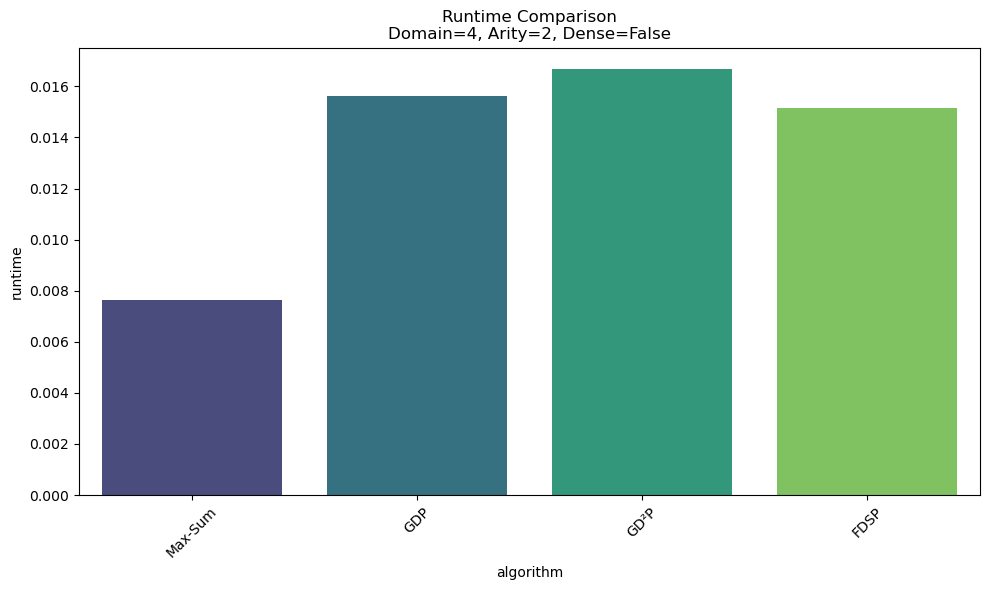

C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


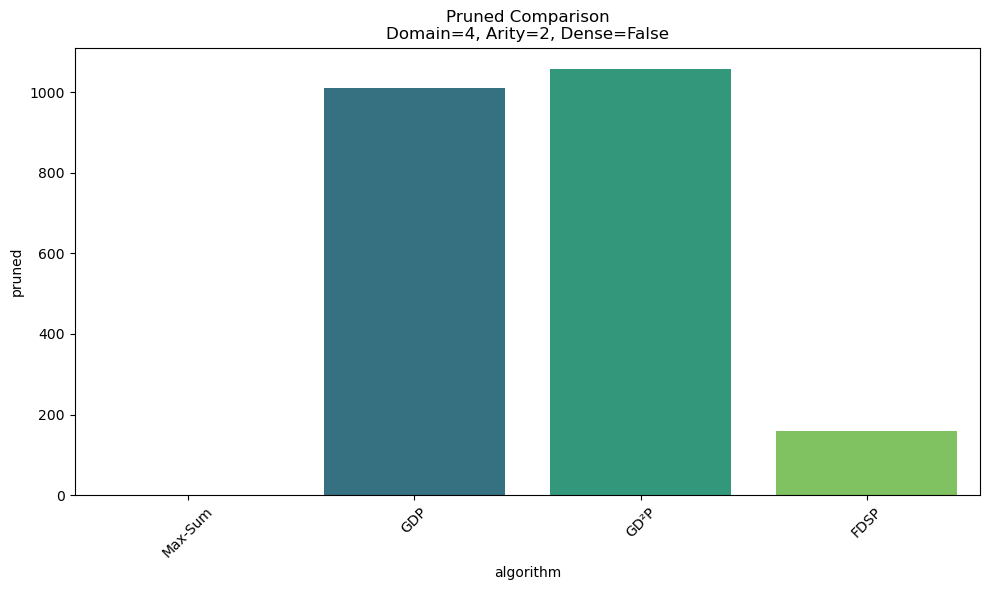

In [663]:
# Setup benchmark
bench = BenchmarkSuite(
    num_vars=10,
    domain_size=4,
    arity=2,
    dense=True,
    iterations=5
)

# Customize for GD2P
bench.cost_type = "uniform"
bench.cost_range = (0, 10)
bench.random_arity = False
bench.coordination_bias = True

# Run grid search (you can also vary params if desired)
bench.run_experiments_grid(
    domain_sizes=[4],
    arities=[2],
    densities=[False],
    repetitions=5
)

bench.run_all_algorithms()
print(pd.DataFrame(bench.results)[['algorithm', 'runtime', 'pruned']])

# Plot comparison
bench.plot_comparison(metric='runtime')
bench.plot_comparison(metric='pruned')

  algorithm   runtime  pruned
0   Max-Sum  0.001997       0
1       GDP  0.001998     131
2      GD²P  0.001000     131
3      FDSP  0.000999      16


C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


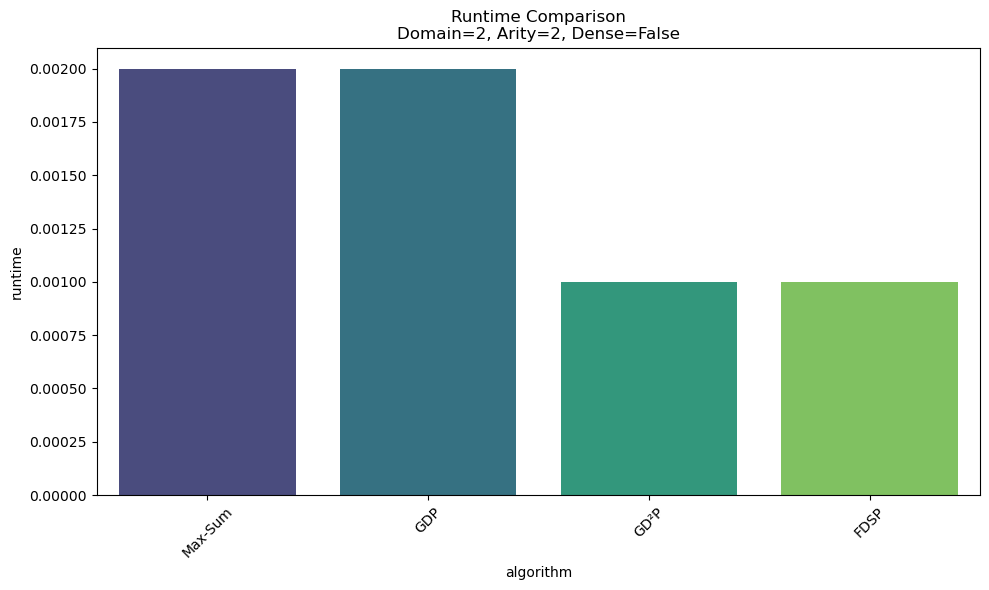

C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


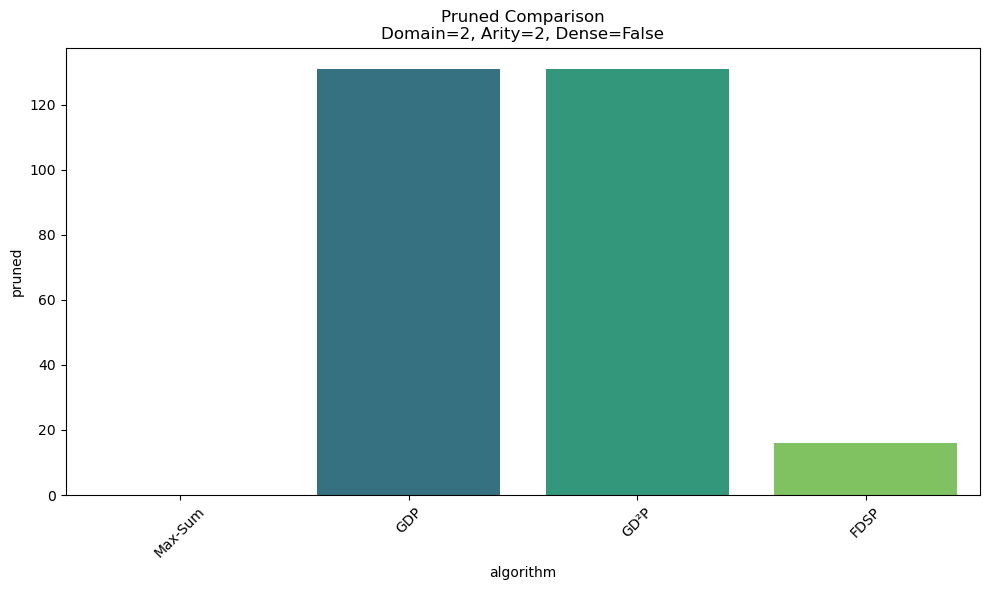

In [613]:
bench = BenchmarkSuite(num_vars=4, domain_size=2, arity=2)
bench.run_all_algorithms()
print(pd.DataFrame(bench.results)[['algorithm', 'runtime', 'pruned']])
bench.plot_comparison(metric='runtime')
bench.plot_comparison(metric='pruned')

  algorithm   runtime  pruned
0   Max-Sum  0.018502       0
1       GDP  0.160439    9327
2      GD²P  0.156812   10742
3      FDSP  0.026047     112


C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


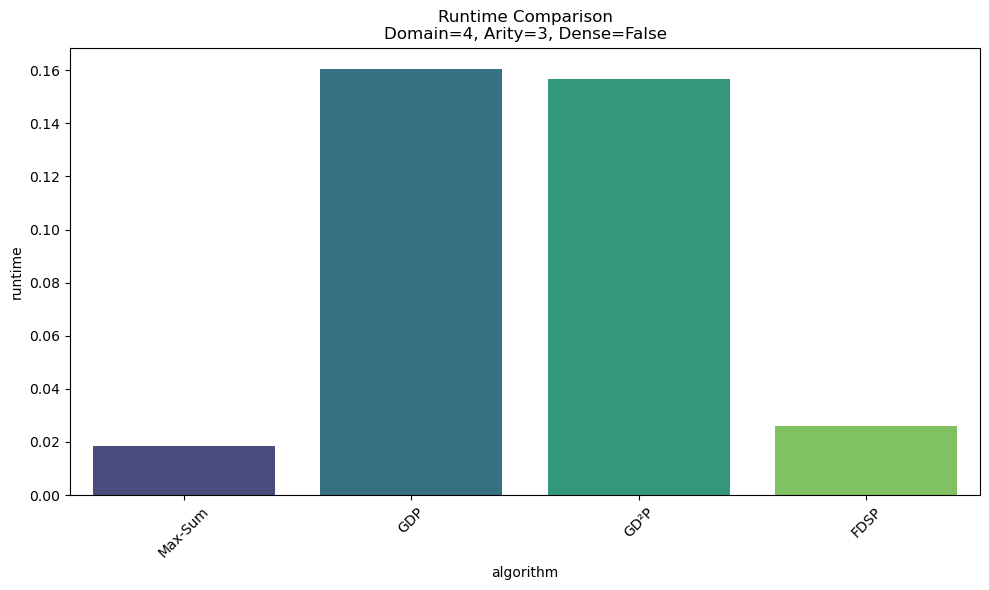

C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


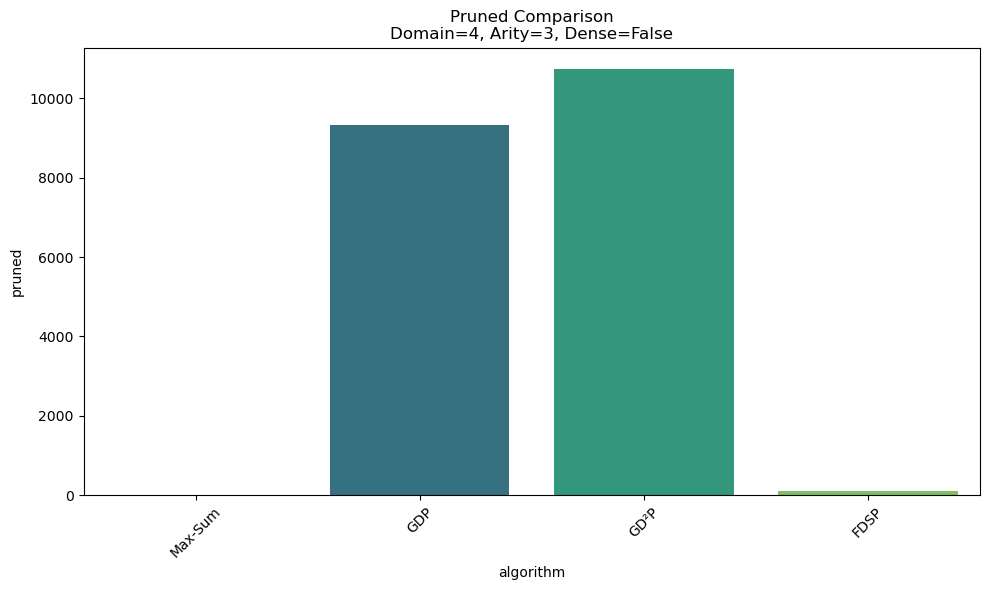

In [615]:
bench = BenchmarkSuite(num_vars=7, domain_size=4, arity=3)
bench.run_all_algorithms()
print(pd.DataFrame(bench.results)[['algorithm', 'runtime', 'pruned']])
bench.plot_comparison(metric='runtime')
bench.plot_comparison(metric='pruned')

  algorithm   runtime  pruned
0   Max-Sum  0.025995       0
1       GDP  0.276063    7330
2      GD²P  0.265750   12362
3      FDSP  0.019352      45


C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


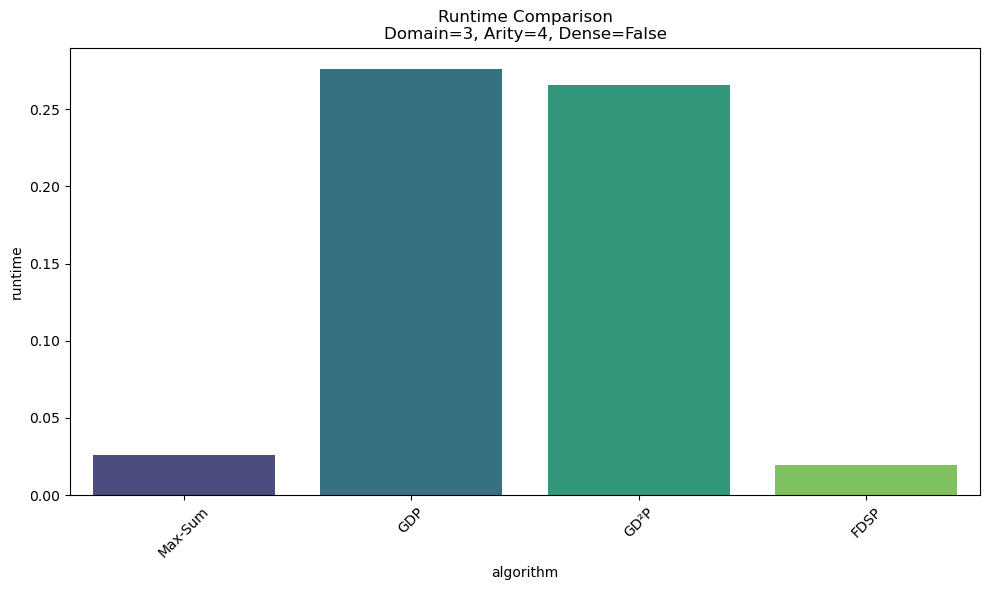

C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


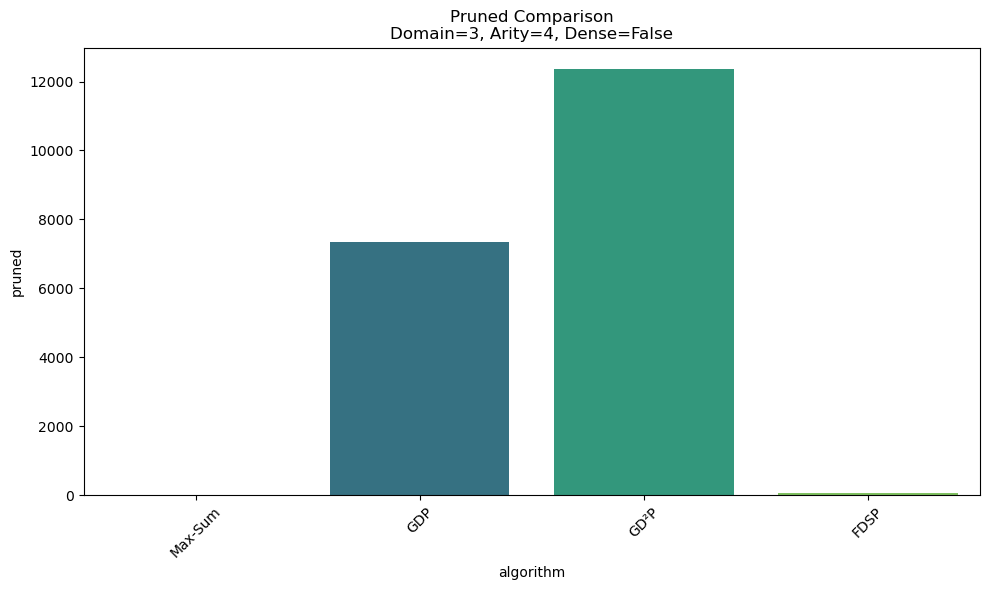

In [617]:
bench = BenchmarkSuite(num_vars=5, domain_size=3, arity=4)
bench.run_all_algorithms()
print(pd.DataFrame(bench.results)[['algorithm', 'runtime', 'pruned']])
bench.plot_comparison(metric='runtime')
bench.plot_comparison(metric='pruned')

Total results collected: 160


C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


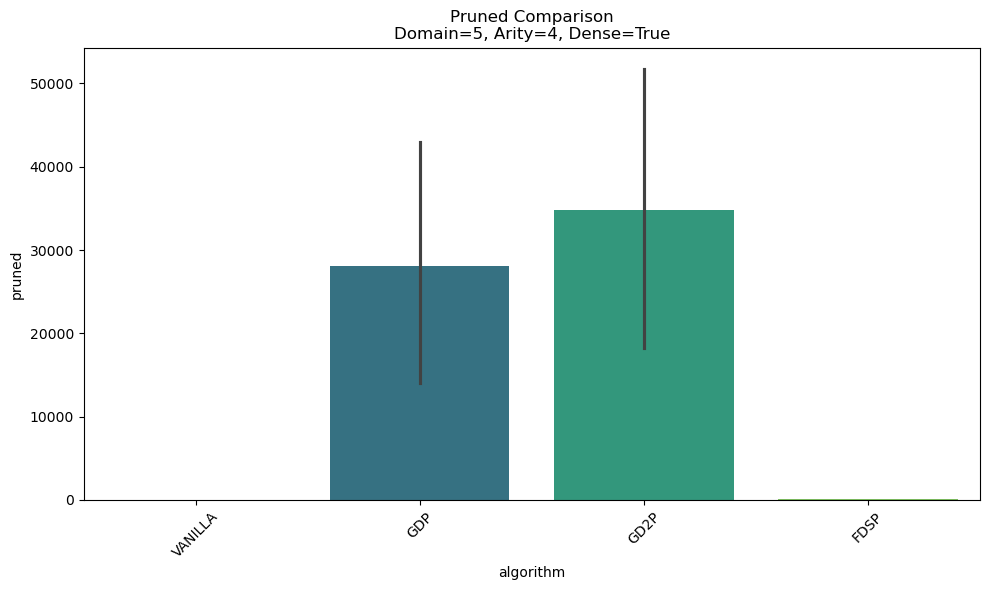

In [619]:
# Example usage
bench = BenchmarkSuite()

# Run experiments (or load saved results)
domain_sizes = [2, 5]
arities = [2, 4]
bench.run_experiments_grid(domain_sizes, arities, densities=[False, True], repetitions=5)

# You can still use all original methods
bench.plot_comparison(metric='pruned')

In [95]:
# Run experiments with all combinations
bench = BenchmarkSuite()
bench.run_experiments_grid(
    domain_sizes=[2, 3, 5],  # 3 sizes
    arities=[2, 3, 4],       # 3 arities
    densities=[False, True], 
    repetitions=5            # 5 runs per configuration
)

# Generate and display tables
bench.print_formatted_tables()

Total results collected: 360
RUNTIME COMPARISON (ms)

|               |   FDSP (mean) |   GD2P (mean) |   GDP (mean) |   VANILLA (mean) |   FDSP (std) |   GD2P (std) |   GDP (std) |   VANILLA (std) |
|:--------------|--------------:|--------------:|-------------:|-----------------:|-------------:|-------------:|------------:|----------------:|
| (2, 2, False) |          0.00 |          0.01 |         0.01 |             0.00 |         0.00 |         0.01 |        0.01 |            0.00 |
| (2, 2, True)  |          0.01 |          0.00 |         0.01 |             0.01 |         0.01 |         0.00 |        0.01 |            0.01 |
| (2, 3, False) |          0.01 |          0.02 |         0.03 |             0.01 |         0.01 |         0.01 |        0.01 |            0.01 |
| (2, 3, True)  |          0.01 |          0.02 |         0.03 |             0.01 |         0.01 |         0.01 |        0.01 |            0.01 |
| (2, 4, False) |          0.01 |          0.08 |         0.08 |      

In [100]:
print(len(bench.results))

360


Total results collected: 12
    algorithm   runtime  pruned
0     VANILLA  0.000992       0
1         GDP  0.002997     203
2        GD2P  0.001999     203
3        FDSP  0.001000      24
4     VANILLA  0.001000       0
..        ...       ...     ...
155      FDSP  0.078448     150
156   VANILLA  0.592830       0
157       GDP  2.383548    1192
158      GD2P  2.316860    1200
159      FDSP  0.075876     150

[160 rows x 3 columns]


C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


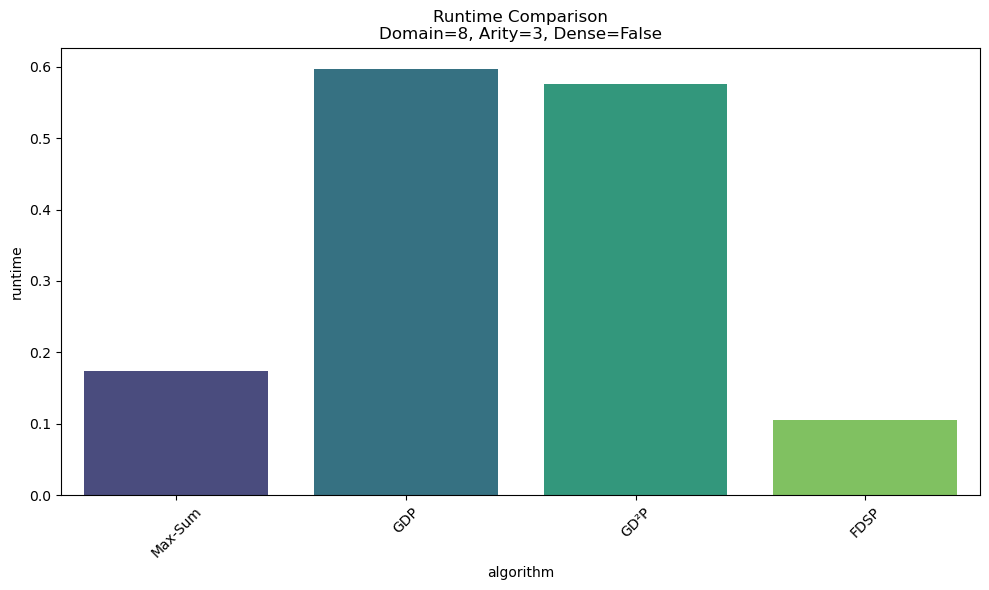

C:\Users\HP\AppData\Local\Temp\ipykernel_19108\3172992917.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='algorithm', y=metric, palette='viridis')


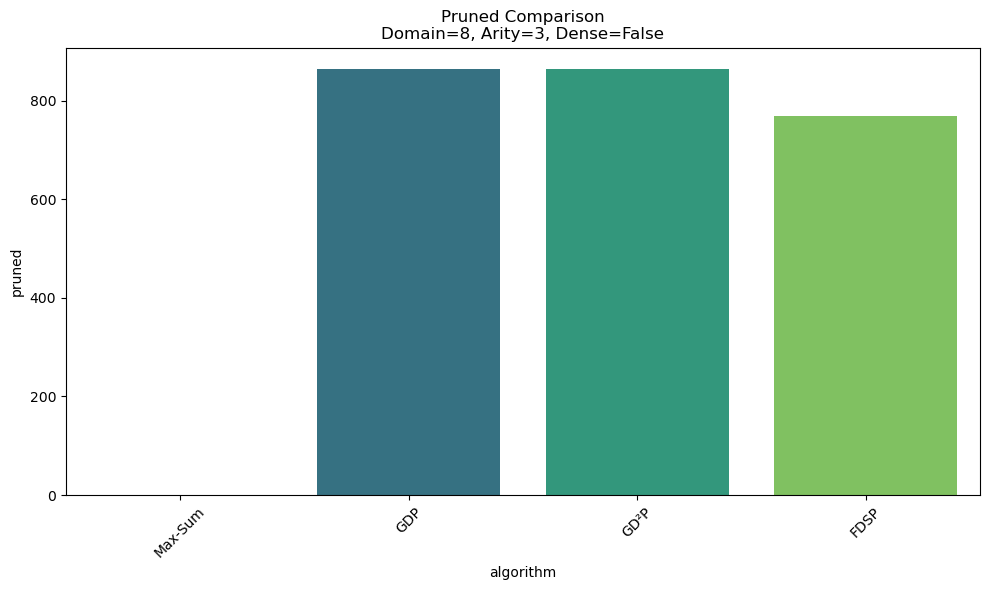

In [208]:
fdsp_sparse = BenchmarkSuite(
    num_vars=12,
    domain_size=8,
    arity=3,
    dense=False,
    iterations=3
)

fdsp_sparse.cost_type = "gaussian"
fdsp_sparse.cost_range = (0, 100)
fdsp_sparse.random_arity = True
fdsp_sparse.coordination_bias = False  # FDSP doesn’t need coordination

fdsp_sparse.run_experiments_grid(
    domain_sizes=[8],
    arities=[3],
    densities=[False],
    repetitions=3
)
fdsp_sparse.run_all_algorithms()
print(pd.DataFrame(bench.results)[['algorithm', 'runtime', 'pruned']])
fdsp_sparse.plot_comparison(metric='runtime')
fdsp_sparse.plot_comparison(metric='pruned')